Price elasticity of demand (PED) is a measure of how sensitive the quantity demanded of a product is in response to price changes. Mathematically it can be described as 

$$PED = \frac{\frac{dQ}{Q}}{\frac{dP}{P}} = \frac{\% \text{ Change in Quantity demanded}}{\% \text{ Change in price}}$$

If $|PED| > 1$, then we say that the product is price elastic of demand and a change decrease in price leads to a proportionally larger change in quantity demanded. 

Similarly, if $|PED| < 1$, then we say that the product is price inelastic of demand and a change in price leads to a proportionally smaller change in quantity demanded. 

We will analyse the PED for different product categories and from there develop a dynamic pricing model using PED that aims to maximize revenue. 

In [4]:
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import statsmodels.api as sm
import numpy as np
from itertools import product
from dotenv import load_dotenv
from scipy.optimize import minimize
import os

In [5]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

load_dotenv(f'{parent_dir}/.env')

postgres_password = os.getenv('POSTGRES_PASSWORD')
postgres_port_no = os.getenv('POSTGRES_PORT_NO')
host = os.getenv('POSTGRES_HOST')
database = os.getenv('POSTGRES_DB')
user = os.getenv('POSTGRES_USER')

# create a database engine
engine = create_engine(f'postgresql://{user}:{postgres_password}@{host}:{postgres_port_no}/{database}')

In [6]:
def create_df():
    connection = engine.connect() # Connect to the database
    query = '''
    SELECT 
        o.date, o.product_id, SUM(o.quantity) AS sales, o.discount_percentage, o.coupon_status, p.category
    FROM 
        online_sales o
    LEFT JOIN
        products p
    ON
        o.product_id = p.product_id
    GROUP BY
        o.date, o.product_id, o.discount_percentage, o.coupon_status, p.category
    '''
    # Read data from the database into a DataFrame
    df = pd.read_sql(query, con=connection)
    return df

df = create_df()
df.head(5)

,date,product_id,sales,discount_percentage,coupon_status,category
0,2019-01-01,B00C3GBCIS,1,0.1,Not Used,Computers&Accessories|Accessories&Peripherals|...
1,2019-01-01,B00J5DYCCA,1,0.1,Not Used,"Home&Kitchen|Heating,Cooling&AirQuality|Fans|E..."
2,2019-01-01,B00KRCBA6E,3,0.1,Not Used,"Home&Kitchen|Heating,Cooling&AirQuality|RoomHe..."
3,2019-01-01,B00KRCBA6E,1,0.1,Used,"Home&Kitchen|Heating,Cooling&AirQuality|RoomHe..."
4,2019-01-01,B00LZLQ624,1,0.1,Not Used,OfficeProducts|OfficePaperProducts|Paper|Stati...


In [7]:
df.describe()

,sales,discount_percentage
count,21802.000000,21802.000000
mean,11.003394,0.198551
std,35.725117,0.081727
min,1.000000,0.100000
25%,1.000000,0.100000
50%,2.000000,0.200000
75%,7.000000,0.300000
max,1191.000000,0.300000


In [8]:
len(df["product_id"].unique())

133

In [9]:
len(df["category"].unique())

68

There are 15315 observations in our dataframe, with 133 unique products and 68 unique categories.

In [10]:
df["discount_percentage"].unique()

array([0.1, 0.2, 0.3])

Interestingly, we only have three `discount_percentage` in the data set, that is 10%, 20% and 30%. 

We also need to make sure that we have the data for each date for each product. To do that, we modify our df:
1. For products that has no entry for a particular date, we set the `sales` to be 0, `discount_percentage` to be the latest `discount_percentage` value possible using forward fill 

In [11]:
all_dates = pd.date_range(start = df["date"].min(), end = df["date"].max()) 
unique_products = df['product_id'].unique()

combinations = product(unique_products, all_dates)
new_df = pd.DataFrame(combinations, columns = ['product_id', 'date'])

new_df.head()

,product_id,date
0,B00C3GBCIS,2019-01-01
1,B00C3GBCIS,2019-01-02
2,B00C3GBCIS,2019-01-03
3,B00C3GBCIS,2019-01-04
4,B00C3GBCIS,2019-01-05


In [12]:
# Ensure 'date' columns are of datetime type in both DataFrames
new_df['date'] = pd.to_datetime(new_df['date'])
df['date'] = pd.to_datetime(df['date'])

# Merge with original DataFrame
merged_df = new_df.merge(
    df[['date', 'product_id', 'category', 'discount_percentage', 'sales', 'coupon_status']], 
    on=['date', 'product_id'], 
    how='left'
)

# Fill missing values
merged_df['sales'] = merged_df['sales'].fillna(0)
merged_df['coupon_status'] = merged_df['coupon_status'].fillna("Not Used")
merged_df['discount_percentage'] = merged_df['discount_percentage'].ffill()  # use forward filling 

# Select only the desired columns
final_df = merged_df[['date', 'product_id', 'category', 'discount_percentage', 'sales', "coupon_status"]]

# Create a dictionary that maps product_id to category from the original DataFrame
product_category_map = df[['product_id', 'category']].dropna().drop_duplicates().set_index('product_id')['category'].to_dict()

# Fill missing category values using the mapping
final_df['category'] = final_df['category'].fillna(final_df['product_id'].map(product_category_map))

final_df.head()


,date,product_id,category,discount_percentage,sales,coupon_status
0,2019-01-01,B00C3GBCIS,Computers&Accessories|Accessories&Peripherals|...,0.1,1.0,Not Used
1,2019-01-02,B00C3GBCIS,Computers&Accessories|Accessories&Peripherals|...,0.1,0.0,Not Used
2,2019-01-03,B00C3GBCIS,Computers&Accessories|Accessories&Peripherals|...,0.1,0.0,Not Used
3,2019-01-04,B00C3GBCIS,Computers&Accessories|Accessories&Peripherals|...,0.1,1.0,Not Used
4,2019-01-05,B00C3GBCIS,Computers&Accessories|Accessories&Peripherals|...,0.1,1.0,Not Used


In [13]:
final_df.groupby(["product_id", "date"])["discount_percentage"].nunique().value_counts()

discount_percentage
1    48545
Name: count, dtype: int64

We now try to visualize how the `discount_percentage` and `sales` change over time for some products

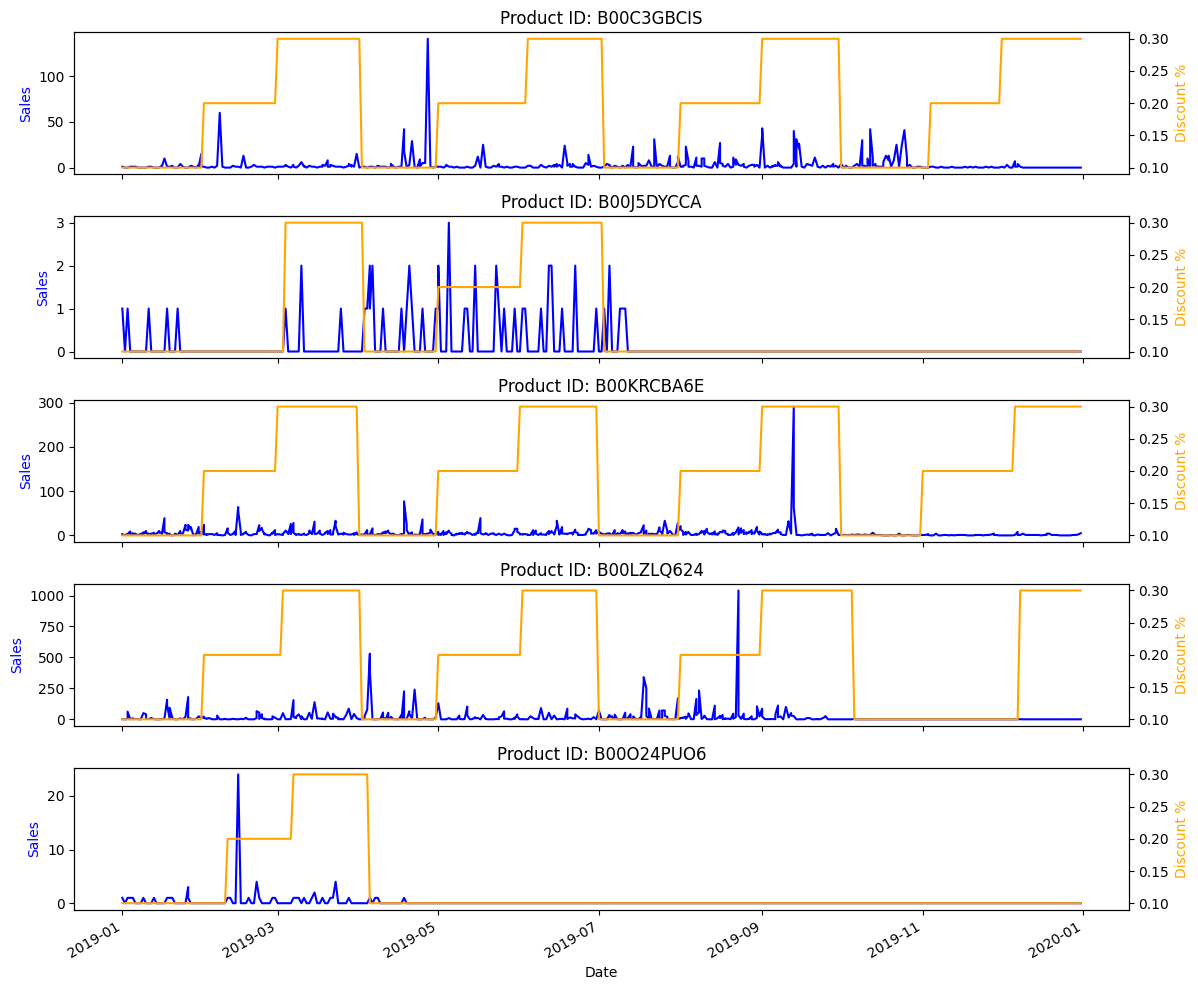

In [14]:
first_five_id = final_df["product_id"].unique()[:5]

# Create figure and axis objects
fig, axes = plt.subplots(nrows = 5, ncols = 1, figsize=(12, 10))

for i, product_id in enumerate(first_five_id):
    test = final_df[final_df["product_id"] == product_id]

    # Plot sales on the first y-axis
    ax1 = axes[i]
    ax1.set_title(f'Product ID: {product_id}')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Sales', color='blue')
    ax1.plot(test['date'], test['sales'], color='blue', label='Sales')

    # Create a second y-axis for discount percentage
    ax2 = ax1.twinx()  
    ax2.set_ylabel('Discount %', color='orange')  
    ax2.plot(test['date'], test['discount_percentage'], color='orange', label='Discount %')

    # Rotate x-ticks for better readability
    fig.autofmt_xdate()

plt.subplots_adjust(hspace=0.5)  # Increase the value of hspace to add more vertical space

plt.tight_layout()
plt.show()

We can observe from the plots that the discount periods seem to be quite regular (1st and 3rd products), and the forward filling method may not capture the discount periods accurately for products with no sales on those days. 

In [15]:
# Merge with original DataFrame
merged_df = new_df.merge(df[['date', 'product_id', 'category', 'discount_percentage', 'sales', 'coupon_status']], 
                          on = ['date', 'product_id'], 
                          how = 'left')

# Fill missing values
merged_df['sales'] = merged_df['sales'].fillna(0)
merged_df['coupon_status'] = merged_df['coupon_status'].fillna("Not Used")

# compute the average Discount_pct for each date
average_discount_pct = merged_df.groupby("date")["discount_percentage"].mean().round(3).reset_index()

average_discount_pct["discount_percentage"].unique()


array([0.1, 0.2, 0.3])

The average `discount_percentage` for each day is the same, suggesting that the discounts are the same for all products every day, therefore it makes more sense to use this discount pct instead of just forward filling

In [16]:
# Merge with original DataFrame
merged_df = new_df.merge(df[['date', 'product_id', 'category', 'sales', 'coupon_status']], 
                          on = ['date', 'product_id'], 
                          how = 'left')

# Fill missing values
merged_df['sales'] = merged_df['sales'].fillna(0)
merged_df['coupon_status'] = merged_df['coupon_status'].fillna("Not Used")

final_df = merged_df.merge(average_discount_pct, on = "date", how = "left")
final_df['category'] = final_df['category'].fillna(final_df['product_id'].map(product_category_map))

final_df.head()

,product_id,date,category,sales,coupon_status,discount_percentage
0,B00C3GBCIS,2019-01-01,Computers&Accessories|Accessories&Peripherals|...,1.0,Not Used,0.1
1,B00C3GBCIS,2019-01-02,Computers&Accessories|Accessories&Peripherals|...,0.0,Not Used,0.1
2,B00C3GBCIS,2019-01-03,Computers&Accessories|Accessories&Peripherals|...,0.0,Not Used,0.1
3,B00C3GBCIS,2019-01-04,Computers&Accessories|Accessories&Peripherals|...,1.0,Not Used,0.1
4,B00C3GBCIS,2019-01-05,Computers&Accessories|Accessories&Peripherals|...,1.0,Not Used,0.1


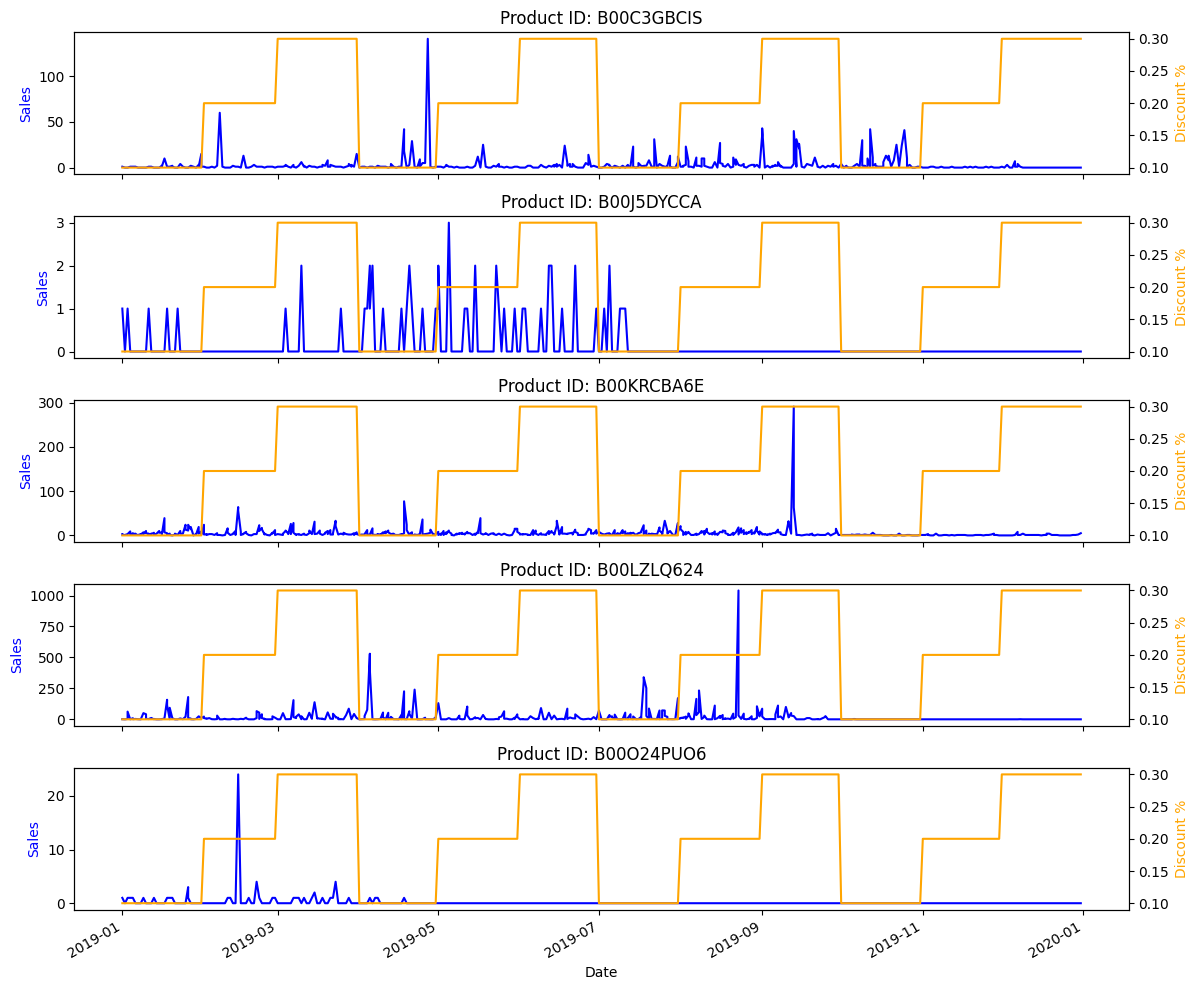

In [17]:
first_five_id = final_df["product_id"].unique()[:5]

# Create figure and axis objects
fig, axes = plt.subplots(nrows = 5, ncols = 1, figsize=(12, 10))

for i, product_id in enumerate(first_five_id):
    test = final_df[final_df["product_id"] == product_id]

    # Plot sales on the first y-axis
    ax1 = axes[i]
    ax1.set_title(f'Product ID: {product_id}')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Sales', color='blue')
    ax1.plot(test['date'], test['sales'], color='blue', label='Sales')

    # Create a second y-axis for discount percentage
    ax2 = ax1.twinx()  
    ax2.set_ylabel('Discount %', color='orange')  
    ax2.plot(test['date'], test['discount_percentage'], color='orange', label='Discount %')

    # Rotate x-ticks for better readability
    fig.autofmt_xdate()

plt.subplots_adjust(hspace=0.5)  # Increase the value of hspace to add more vertical space

plt.tight_layout()
plt.show()

Next, we aggregate the sales data for each category 

In [18]:
df_cat = final_df.groupby(["date", "category", "discount_percentage", "coupon_status"])["sales"].sum().reset_index()

df_cat.head()

,date,category,discount_percentage,coupon_status,sales
0,2019-01-01,Computers&Accessories|Accessories&Peripherals|...,0.1,Not Used,8.0
1,2019-01-01,Computers&Accessories|Accessories&Peripherals|...,0.1,Used,56.0
2,2019-01-01,Computers&Accessories|Accessories&Peripherals|...,0.1,Not Used,0.0
3,2019-01-01,Computers&Accessories|Accessories&Peripherals|...,0.1,Not Used,0.0
4,2019-01-01,Computers&Accessories|Accessories&Peripherals|...,0.1,Not Used,0.0


We still have quite a number of days whereby there is no sale for some categories even though we have aggregated the sales data. However, since there is only a change in price whenever the `discount_percentage` changes, we can aggregate the sales data by "discount_period" 

In [19]:
# Identify when the discount rate changes
average_discount_pct['discount_change'] = average_discount_pct['discount_percentage'].shift(1) - average_discount_pct['discount_percentage']
average_discount_pct['change'] = np.isclose(average_discount_pct['discount_change'], 0) == False

# Create a cumulative count to label each constant discount period
average_discount_pct['discount_period'] = average_discount_pct['change'].cumsum()

df_cat1 = df_cat.merge(average_discount_pct, 
             on = ["date" ,"discount_percentage"], 
             how = "left")

df_cat1.head()

,date,category,discount_percentage,coupon_status,sales,discount_change,change,discount_period
0,2019-01-01,Computers&Accessories|Accessories&Peripherals|...,0.1,Not Used,8.0,NaN,True,1
1,2019-01-01,Computers&Accessories|Accessories&Peripherals|...,0.1,Used,56.0,NaN,True,1
2,2019-01-01,Computers&Accessories|Accessories&Peripherals|...,0.1,Not Used,0.0,NaN,True,1
3,2019-01-01,Computers&Accessories|Accessories&Peripherals|...,0.1,Not Used,0.0,NaN,True,1
4,2019-01-01,Computers&Accessories|Accessories&Peripherals|...,0.1,Not Used,0.0,NaN,True,1


In [20]:
# Aggregate sales by discount period and category and coupon status
df_cat_period_1 = df_cat1.groupby(['discount_period', 'category', 'coupon_status']).agg(
    total_sales = ('sales', 'sum'),                # Sum of sales
    discount_percentage = ('discount_percentage', 'first')
).reset_index()

# remove transactions that did not use coupons
df_cat_period_used = df_cat_period_1[df_cat_period_1["coupon_status"] == "Used"]

unique_discount_periods = df_cat1['discount_period'].unique()
unique_categories = df_cat1['category'].unique()

# Create a complete DataFrame
complete_index = pd.MultiIndex.from_product(
    [unique_discount_periods, unique_categories, ['Used']],
    names=['discount_period', 'category', 'coupon_status']
)

# Create an empty DataFrame with the complete index
complete_df = pd.DataFrame(index=complete_index).reset_index()

# Merge the complete DataFrame with df_cat_period_used
df_cat_period = pd.merge(complete_df, df_cat_period_used, on=['discount_period', 'category', 'coupon_status'], how='left')

# Replace NaN values in total_sales with 0
df_cat_period['total_sales'] = df_cat_period['total_sales'].fillna(0)

# Fill missing Discount_pct values using the mode or another strategy
df_cat_period['discount_percentage'] = df_cat_period.groupby('discount_period')['discount_percentage'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 0))

# Display the resulting DataFrame
df_cat_period.head()

,discount_period,category,coupon_status,total_sales,discount_percentage
0,1,Computers&Accessories|Accessories&Peripherals|...,Used,860.0,0.1
1,1,Computers&Accessories|Accessories&Peripherals|...,Used,10.0,0.1
2,1,Computers&Accessories|Accessories&Peripherals|...,Used,516.0,0.1
3,1,Computers&Accessories|Accessories&Peripherals|...,Used,1.0,0.1
4,1,Computers&Accessories|Accessories&Peripherals|...,Used,190.0,0.1


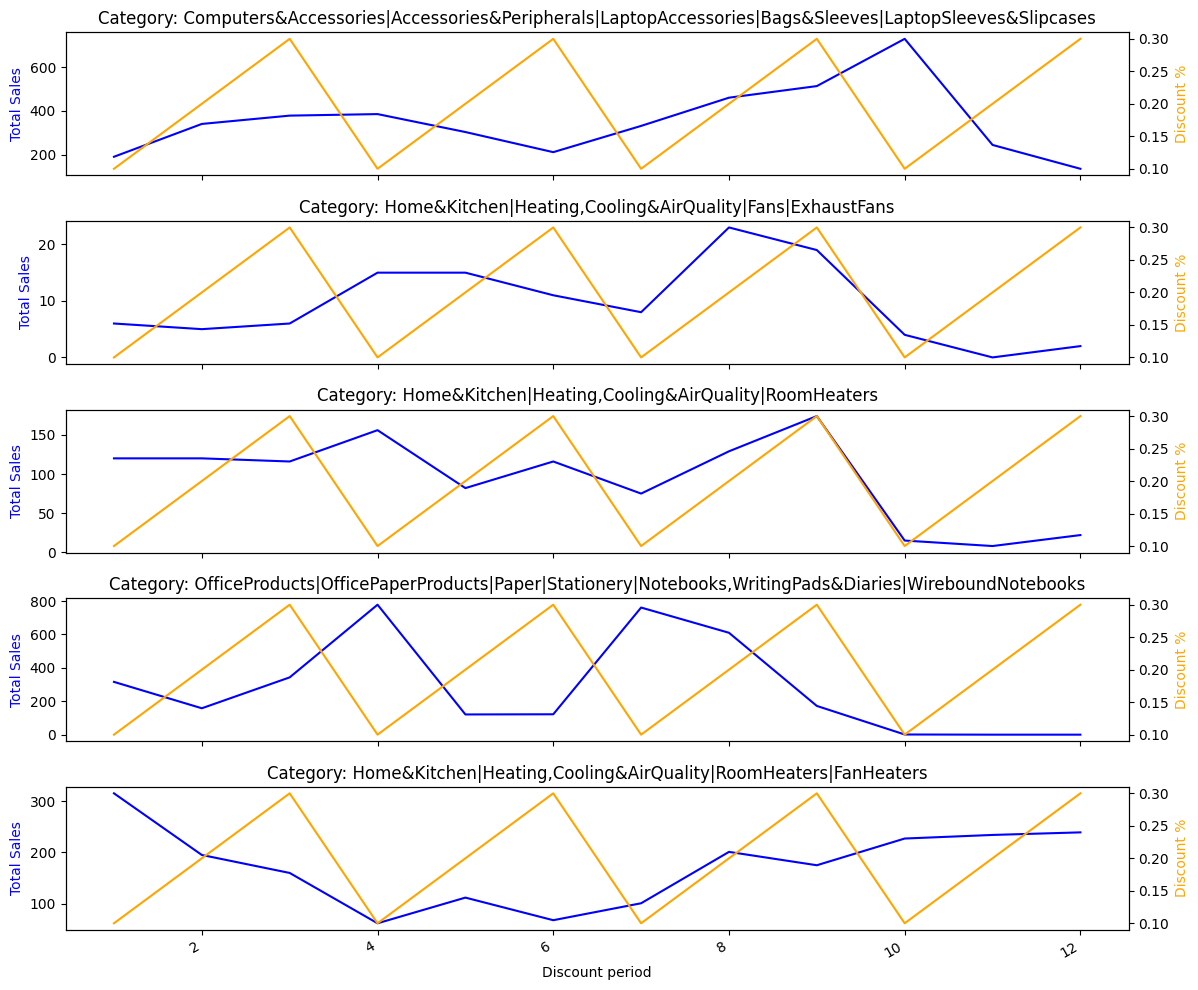

In [21]:
first_five_id = final_df["category"].unique()[:5]

# Create figure and axis objects
fig, axes = plt.subplots(nrows = 5, ncols = 1, figsize=(12, 10))

for i, category in enumerate(first_five_id):
    test = df_cat_period[df_cat_period["category"] == category]

    # Plot sales on the first y-axis
    ax1 = axes[i]
    ax1.set_title(f'Category: {category}')
    ax1.set_xlabel('Discount period')
    ax1.set_ylabel('Total Sales', color='blue')
    ax1.plot(test['discount_period'], test['total_sales'], color='blue', label='Sales')

    # Create a second y-axis for discount percentage
    ax2 = ax1.twinx()  
    ax2.set_ylabel('Discount %', color='orange')  
    ax2.plot(test['discount_period'], test['discount_percentage'], color='orange', label='Discount %')

    # Rotate x-ticks for better readability
    fig.autofmt_xdate()

plt.subplots_adjust(hspace=0.5) 
plt.tight_layout()
plt.show()

We will use a log-log regression model to estimate the price elasticity of demand for each category. The model is set up using 

- **Dependent variable** (Y) = $\log\{total\_sales\}$
- **Independent variable 1** (X1) = $\log\{discount\_percentage\}$
- **Independent variable 2** (X2) = Dummy variable for each quarter to control for seasonality 

$$\log\{total\_sales\} = \beta_0 + \beta_1\log\{discount\_percentage\} + \beta_2 I(Quarter = 1) + ... $$

where $\beta_1$ represents the PED. X2 was set up to take into account for time and seasonality 

In [22]:
df_cat_period['two_month_interval'] = np.where(df_cat_period['discount_period'] <= 2, 'Jan-Feb',
                                               np.where(df_cat_period['discount_period'] <= 4, 'Mar-Apr',
                                                        np.where(df_cat_period['discount_period'] <= 6, 'May-Jun',
                                                                 np.where(df_cat_period['discount_period'] <= 8, 'Jul-Aug',
                                                                          np.where(df_cat_period['discount_period'] <= 10, 'Sep-Oct', 'Nov-Dec')))))                                              

df_dummy = pd.get_dummies(df_cat_period, columns=['two_month_interval'], prefix='interval', drop_first=True)

ped_results = pd.DataFrame(columns=['category', 'PED'])

for category, group in df_cat_period.groupby('category'):
    group_dummies = df_dummy[df_dummy['category'] == category].drop(columns=[ 'coupon_status', 'category', 'total_sales', 'discount_percentage', "discount_period"]).astype(int)

    X = np.log(group['discount_percentage'])
    y = np.log(group['total_sales'] + 1)
    X = pd.concat([X, group_dummies], axis=1)
    
    model = sm.OLS(y, sm.add_constant(X)).fit()

    # Get the coefficient for the log of discount percentage (price elasticity)
    discount_coef = model.params['discount_percentage']
    r_squared = model.rsquared
    current_result = pd.DataFrame({'category': [category], 'PED': [discount_coef], 'R^2': [r_squared] })

    ped_results = pd.concat([ped_results, current_result], ignore_index=True)

ped_results.head()

C:\Users\Vit_Chun\AppData\Local\Temp\ipykernel_24736\1889865018.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ped_results = pd.concat([ped_results, current_result], ignore_index=True)


,category,PED,R^2
0,Computers&Accessories|Accessories&Peripherals|...,0.245420,0.240415
1,Computers&Accessories|Accessories&Peripherals|...,0.467961,0.875660
2,Computers&Accessories|Accessories&Peripherals|...,-0.950731,0.840031
3,Computers&Accessories|Accessories&Peripherals|...,0.485052,0.829440
4,Computers&Accessories|Accessories&Peripherals|...,-0.043481,0.779391


We can see that some of the R^2 values may not be so good, suggesting a poor fit of the regression model. One reason could be due to too little sales for some categories, thus the model may not be able to capture the relationship accurately. Therefore, it would not be suitable to use the PED obtained from such models. 

As such, for categories with $R^2 < 0.5$, we say that more data is required for us to derive te PED, hence we set them to be -1, that is, we assume that each unit of price drop leads to one unit increase of demand

In [23]:
ped_results.loc[ped_results["R^2"] < 0.5, "PED"] = -1

C:\Users\Vit_Chun\AppData\Local\Temp\ipykernel_24736\2864508587.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='category', y='PED', data=ped_results, palette='viridis')
C:\Users\Vit_Chun\AppData\Local\Temp\ipykernel_24736\2864508587.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


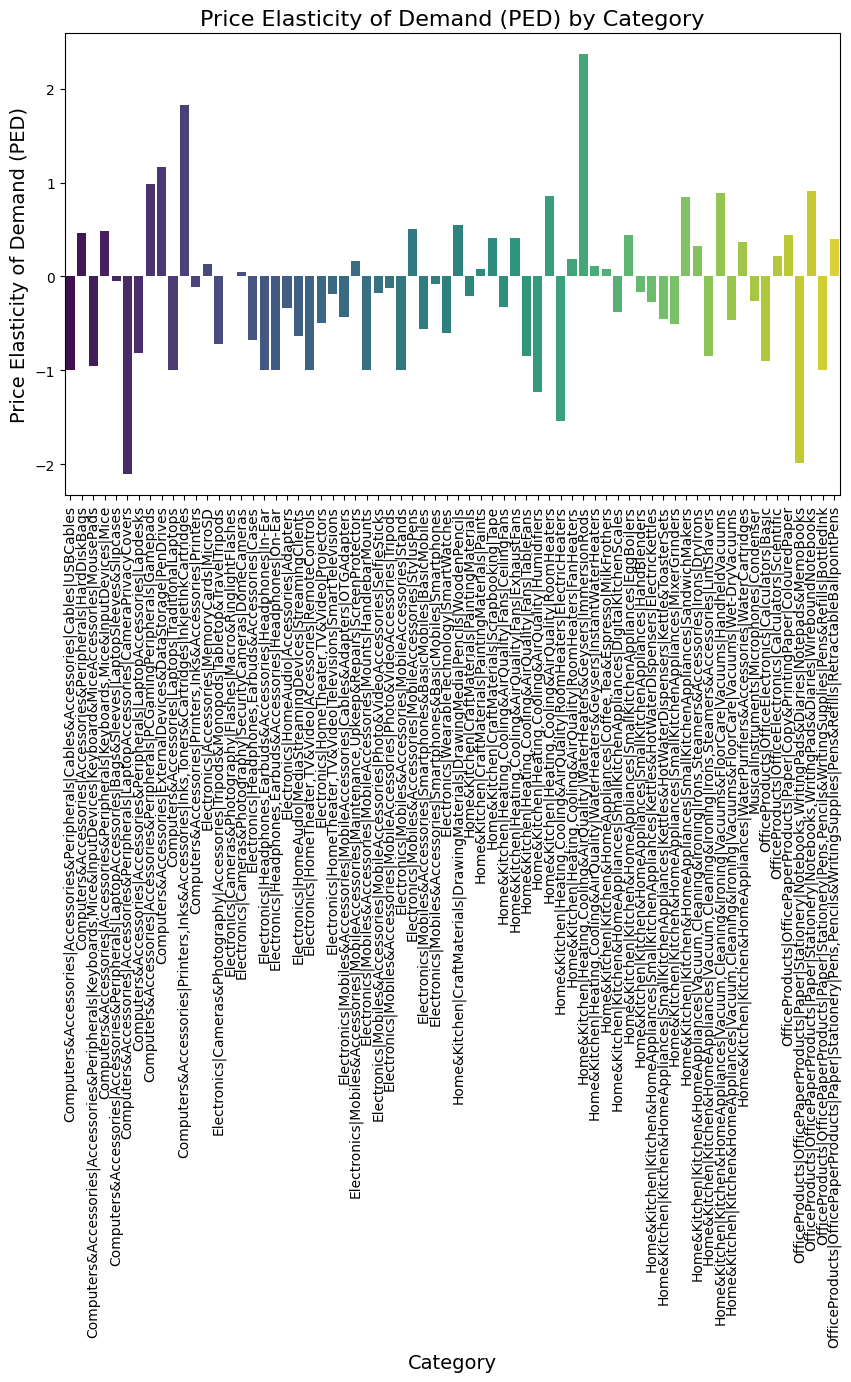

In [24]:
plt.figure(figsize=(10, 6))

sns.barplot(x='category', y='PED', data=ped_results, palette='viridis')
plt.title('Price Elasticity of Demand (PED) by Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Price Elasticity of Demand (PED)', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [25]:
ped_results = ped_results.drop(columns=['R^2'])
ped_results.to_csv('ped_results.csv', index=False)

### Developing a pricing model

We will make use of the forecasted demand and price elasticity to develop a pricing model that maximizes revenue. 

Given PED, we can express our demand as: 

$$
D = D_{forecast} \times \left(\frac{P_{new}}{P_{no\_discount}}\right)^{PED}
$$

and the revenue function will be 

$$
R(Discount\_pct) = P \times D = P \times D_{forecast} \times \left(\frac{P_{new}}{P_{no\_discount}}\right)^{PED}
$$

where $P_{new} = P_{no\_discount} \times (1 - Discount\_pct)$

our goal is to find the optimal `discount_percentage` that maximizes revenue, $R(P)$. The following function allows us to find the new revenue given the ped of the product, the forecast demand and the price. 

In [1]:
def expected_revenue(price, discount, forecast_demand, ped):
    p_new = price * (1 - discount)
    d_new = forecast_demand * (p_new / price) ** ped
    return d_new, p_new, p_new * d_new

In [30]:
def create_product_df():
    connection = engine.connect() # Connect to the database
    query = '''
    SELECT * FROM products 
    '''
    # Read data from the database into a DataFrame
    df = pd.read_sql(query, con=connection)
    return df

product_df = create_product_df()
ped_results = pd.read_csv('ped_results.csv')
forecast = pd.read_csv('../demand_forecast/forecast.csv')

In [46]:
forecast['date'] = pd.to_datetime(forecast['date'])
forecast['month'] = forecast['date'].dt.to_period('M')
monthly_forecast = forecast.groupby(['product', 'month']).sum('sales').reset_index()

monthly_forecast = monthly_forecast.merge(product_df[['product_id', 'product_name', 'category', 'actual_price']], 
                                          left_on = 'product', right_on = 'product_id',
                                          how = 'left')

monthly_forecast = monthly_forecast.merge(ped_results, on = 'category', how = 'left')
monthly_forecast = monthly_forecast.drop('product', axis = 1)
monthly_forecast['base_cat'] = monthly_forecast['category'].apply(lambda x: x.split('|')[0])
monthly_forecast['month'] = monthly_forecast['month'].dt.strftime('%B')

monthly_forecast.to_csv('forecast_with_ped.csv', index = False)